In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet
from upsetplot import from_contents

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/new_plots_forYuXuan/"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

In [3]:
# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]
csv_files = [f for f in csv_files if f.startswith("AGE_")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    #key = '_'.join(filename.split("_")[0:4])
    key = filename
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

In [4]:
mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)

In [5]:
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [6]:
di = {'AGE_Mid_Old_Rapa Early_20240606.csv':"MidOld_RapaEarly",
       'AGE_YoungRapa Adult_OldRapa Early_Rapa Early_20240606.csv':"YoungRapaAdult_OldRapaEarly",
       'AGE_MidRapa Adult_OldRapa Late_Rapa Early_20240606.csv':"MidRapaAdult_OldRapaLate",
       'AGE_YoungRapa Adult_MidRapa Early_Rapa Early_20240606.csv':"YoungRapaAdult_MidRapaEarly",
       'AGE_Young_Mid_Control_20240606.csv':"YoungMid_Control",
       'AGE_Mid_Old_Control_20240606.csv':"MidOld_Control",
       'AGE_Young_Mid_Rapa Adult_20240606.csv':"YoungMid_RapaAdult",
       'AGE_Young_Old_Rapa Adult_20240606.csv':"YoungOld_RapaAdult",
       'AGE_Mid_Old_Rapa Adult_20240606.csv':"MidOld_RapaAdult",
       'AGE_MidControl_OldRapa Late_Rapa Early_20240606.csv':"MidControl_OldRapaLate",
       'AGE_Young_Old_Control_20240606.csv':"YoungOld_Control"}
mer = mer.replace({"fullname": di})

In [26]:
merX = mer[mer["log2FoldChange"] > 0]

In [27]:
RapaAdult_MidOld = merX[merX["fullname"] == "MidOld_RapaAdult"]["OTU"]
RapaAdult_YoungMid = merX[merX["fullname"] == "YoungMid_RapaAdult"]["OTU"]

Control_MidOld = merX[merX["fullname"] == "MidOld_Control"]["OTU"]
Control_YoungMid = merX[merX["fullname"] == "YoungMid_Control"]["OTU"]

YoungRapaAdult_MidRapaEarly = merX[merX["fullname"] == "YoungRapaAdult_MidRapaEarly"]["OTU"]
MidOld_RapaEarly = merX[merX["fullname"] == "MidOld_RapaEarly"]["OTU"]
MidRapaAdult_OldRapaLate = merX[merX["fullname"] == "MidRapaAdult_OldRapaLate"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85175/3003607519.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


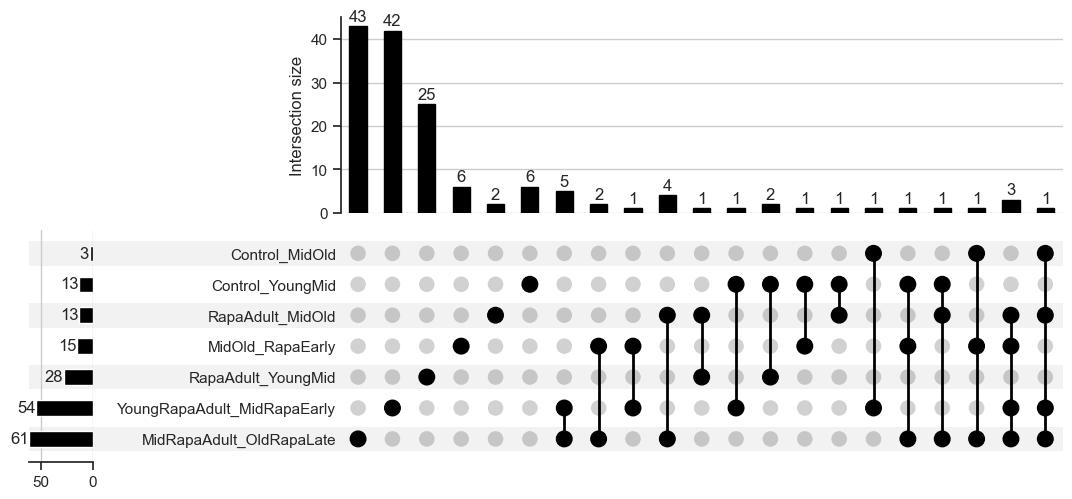

In [28]:
changes = from_contents(
    {"RapaAdult_YoungMid": RapaAdult_YoungMid, "RapaAdult_MidOld": RapaAdult_MidOld,
    "Control_MidOld":Control_MidOld, "Control_YoungMid":Control_YoungMid,
    "YoungRapaAdult_MidRapaEarly":YoungRapaAdult_MidRapaEarly, "MidOld_RapaEarly":MidOld_RapaEarly,
    "MidRapaAdult_OldRapaLate":MidRapaAdult_OldRapaLate}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/Memory_upregulated_uppset.pdf")

In [29]:
pd.Series(list(set(MidOld_RapaEarly) & set(MidRapaAdult_OldRapaLate)))

0     ASV_24
1     ASV_73
2    ASV_248
3     ASV_95
4    ASV_113
5    ASV_175
6     ASV_51
dtype: object

In [14]:
merX = mer[mer["log2FoldChange"] < 0]

In [15]:
RapaAdult_MidOld = merX[merX["fullname"] == "MidOld_RapaAdult"]["OTU"]
RapaAdult_YoungMid = merX[merX["fullname"] == "YoungMid_RapaAdult"]["OTU"]

Control_MidOld = merX[merX["fullname"] == "MidOld_Control"]["OTU"]
Control_YoungMid = merX[merX["fullname"] == "YoungMid_Control"]["OTU"]

YoungRapaAdult_MidRapaEarly = merX[merX["fullname"] == "YoungRapaAdult_MidRapaEarly"]["OTU"]
MidOld_RapaEarly = merX[merX["fullname"] == "MidOld_RapaEarly"]["OTU"]
MidRapaAdult_OldRapaLate = merX[merX["fullname"] == "MidRapaAdult_OldRapaLate"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85175/3594114774.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


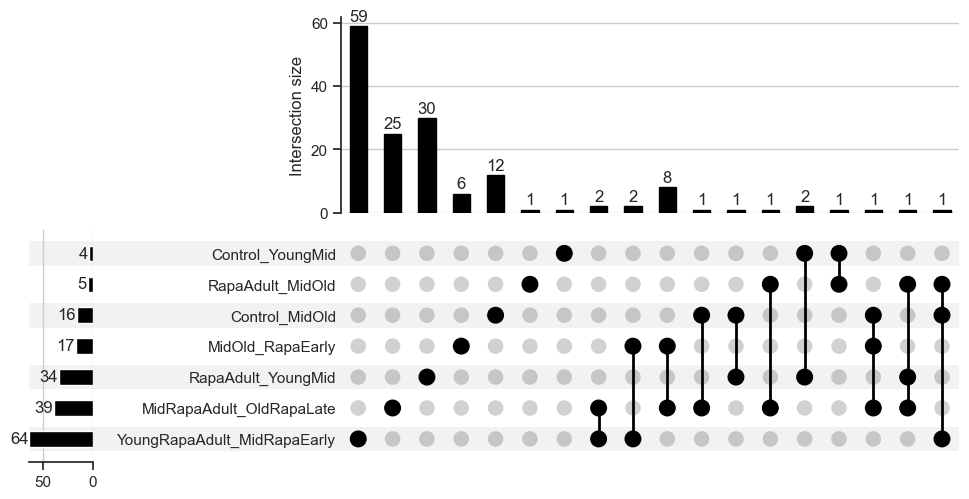

In [16]:
changes = from_contents(
    {"RapaAdult_YoungMid": RapaAdult_YoungMid, "RapaAdult_MidOld": RapaAdult_MidOld,
    "Control_MidOld":Control_MidOld, "Control_YoungMid":Control_YoungMid,
    "YoungRapaAdult_MidRapaEarly":YoungRapaAdult_MidRapaEarly, "MidOld_RapaEarly":MidOld_RapaEarly,
    "MidRapaAdult_OldRapaLate":MidRapaAdult_OldRapaLate}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/Memory_downregulated_uppset.pdf")

In [25]:
pd.Series(list(set(MidOld_RapaEarly) & set(MidRapaAdult_OldRapaLate)))

0      ASV_5
1     ASV_16
2    ASV_194
3    ASV_202
4      ASV_4
5     ASV_23
6     ASV_58
7     ASV_49
8    ASV_104
dtype: object

In [20]:
upreg = mer[mer["log2FoldChange"] > 0]
upreg["reg"] = "up_in_older"
downreg = mer[mer["log2FoldChange"] < 0]
downreg["reg"] = "down_in_older"

mer = pd.concat([upreg, downreg])

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85175/31300130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upreg["reg"] = "up_in_older"
/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85175/31300130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downreg["reg"] = "down_in_older"


In [22]:
## Do chronics
memory = mer[mer["fullname"].isin(["YoungMid_RapaAdult",
                                  'YoungMid_Control',
                                   'MidOld_Control',
                                  'MidOld_RapaAdult',
                                  "YoungRapaAdult_MidRapaEarly",
                                  "MidOld_RapaEarly", "MidRapaAdult_OldRapaLate"])]

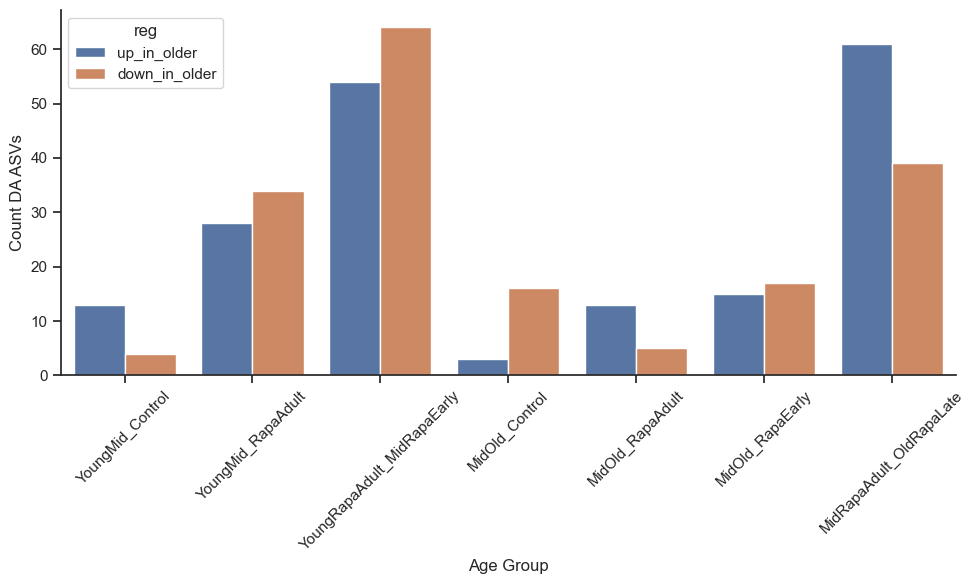

In [23]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize = (10, 6))
# Create the bar plot
sns.countplot(memory, x="fullname",
             order = ['YoungMid_Control', 
            "YoungMid_RapaAdult", "YoungRapaAdult_MidRapaEarly", 'MidOld_Control',
            'MidOld_RapaAdult', "MidOld_RapaEarly", "MidRapaAdult_OldRapaLate"], hue = "reg")

plt.xlabel("Age Group")
plt.ylabel("Count DA ASVs")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/memory_barplot.pdf")
plt.savefig(f"{path}/memory_barplot.png")

## Plot expression of these bacteria

In [30]:
norm_otu = pd.read_csv("../analysis/norm-CLEAN_ASVs_counts_merged_20240530.tsv", sep = "\t")
norm_otu.set_index('Sample_ID', inplace = True)
metadata = pd.read_csv("../metadata_rapaInter.csv")

# Sort metadata according to columnames to help understand groups
sorter = list(norm_otu.columns[1:])
metadata.Sample_ID = metadata.Sample_ID.astype("category")
metadata.Sample_ID = metadata.Sample_ID.cat.set_categories(sorter)
metadata = metadata.sort_values(["Sample_ID"])
metadata.set_index("Sample_ID", inplace = True)

# Transpose df and merge with metadata
expr = pd.merge(norm_otu.T, metadata, left_index = True, right_index = True)

In [31]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [56]:
ots = {}

for e in ["ASV_5", "ASV_16", "ASV_194", "ASV_202", "ASV_4", "ASV_23", "ASV_58", "ASV_49", "ASV_104"]:
    ots[list(mer[mer["OTU"] == e]["Genus"].unique())[-1]] = e
    print(e)
    display(mer[mer["OTU"] == e].loc[:, ["log2FoldChange", "padj", "Comparison", "Age", "Sex", "Family", "Genus"]])

ASV_5


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
1,-3.220201,2.450132e-02,AGEMales,Young,Old,Muribaculaceae,NaN
106,4.151449,4.538668e-07,AGEMales,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
322,2.433222,7.744900e-06,AGE,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
425,-4.086727,1.892263e-13,AGE,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
525,-2.440580,3.535427e-02,ControlRapaLate,Old,F,Muribaculaceae,NaN
626,3.597881,2.784424e-08,ControlRapaAdult,Old,F,Muribaculaceae,NaN
973,3.262404,3.539703e-03,RapaLateRapaEarly,Old,F,Muribaculaceae,NaN
1109,-4.994257,2.681311e-14,AGEFemales,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
1295,-3.931749,1.015223e-05,AGEMales,Mid,Old,Muribaculaceae,NaN
1455,2.507180,1.515888e-02,ControlRapaAdult,Mid,F,Muribaculaceae,NaN


ASV_16


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
231,-1.045112,0.014875,RapaAdultRapaEarly,Mid,ALL,Lactobacillaceae,Lactobacillus
324,1.386054,0.023268,AGE,YoungRapa Adult,OldRapa Early,Lactobacillaceae,Lactobacillus
428,-1.884787,0.000068,AGE,MidRapa Adult,OldRapa Late,Lactobacillaceae,Lactobacillus
631,1.610595,0.044965,ControlRapaAdult,Old,F,Lactobacillaceae,Lactobacillus
858,1.783065,0.037843,SexRapaEarly,Old,20240404.csv,Lactobacillaceae,Lactobacillus
1111,-2.634258,0.000039,AGEFemales,MidRapa Adult,OldRapa Late,Lactobacillaceae,Lactobacillus
1457,1.697440,0.044061,ControlRapaAdult,Mid,F,Lactobacillaceae,Lactobacillus
1529,1.392291,0.008221,AGE,Young,Mid,Lactobacillaceae,Lactobacillus
1854,1.837094,0.010258,SexControl,Young,20240404.csv,Lactobacillaceae,Lactobacillus
2265,-1.841910,0.030389,RapaAdultRapaLate,Old,F,Lactobacillaceae,Lactobacillus


ASV_194


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
44,-2.074046,0.021061,AGEMales,Young,Old,Lactobacillaceae,Lactobacillus
272,-1.316427,0.005269,RapaAdultRapaEarly,Mid,ALL,Lactobacillaceae,Lactobacillus
480,-1.785175,0.002094,AGE,MidRapa Adult,OldRapa Late,Lactobacillaceae,Lactobacillus
1143,-2.543381,0.000374,AGEFemales,MidRapa Adult,OldRapa Late,Lactobacillaceae,Lactobacillus
1382,2.137304,0.017083,AGEFemales,Young,Mid,Lactobacillaceae,Lactobacillus
1560,2.459782,0.000060,AGE,Young,Mid,Lactobacillaceae,Lactobacillus
1869,1.652492,0.024917,SexControl,Young,20240404.csv,Lactobacillaceae,Lactobacillus


ASV_202


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
274,-1.183336,0.010623,RapaAdultRapaEarly,Mid,ALL,Lactobacillaceae,Lactobacillus
481,-1.340012,0.018224,AGE,MidRapa Adult,OldRapa Late,Lactobacillaceae,Lactobacillus
1145,-2.048865,0.001810,AGEFemales,MidRapa Adult,OldRapa Late,Lactobacillaceae,Lactobacillus
1384,2.153234,0.029776,AGEFemales,Young,Mid,Lactobacillaceae,Lactobacillus
1563,2.551911,0.000060,AGE,Young,Mid,Lactobacillaceae,Lactobacillus
3196,-1.841842,0.014896,RapaAdultRapaEarly,Old,ALL,Lactobacillaceae,Lactobacillus


ASV_4


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
105,4.115574,3.771161e-07,AGEMales,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
321,2.414899,7.296138e-06,AGE,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
424,-4.049831,3.053958e-13,AGE,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
524,-2.713904,1.326902e-02,ControlRapaLate,Old,F,Muribaculaceae,NaN
625,3.306636,1.491558e-07,ControlRapaAdult,Old,F,Muribaculaceae,NaN
972,3.275466,4.103348e-03,RapaLateRapaEarly,Old,F,Muribaculaceae,NaN
1108,-4.951498,1.552592e-13,AGEFemales,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
1294,-4.092257,5.313885e-06,AGEMales,Mid,Old,Muribaculaceae,NaN
1454,2.283100,1.787783e-02,ControlRapaAdult,Mid,F,Muribaculaceae,NaN
1925,1.473523,2.664964e-02,ControlRapaAdult,Mid,ALL,Muribaculaceae,NaN


ASV_23


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
111,1.454555,0.002126,AGEMales,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
430,-0.773910,0.026817,AGE,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
861,-1.191873,0.040216,SexRapaEarly,Old,20240404.csv,Muribaculaceae,NaN
1298,-1.557307,0.013559,AGEMales,Mid,Old,Muribaculaceae,NaN
2268,-1.123270,0.025010,RapaAdultRapaLate,Old,F,Muribaculaceae,NaN
2355,-0.899933,0.013156,AGEFemales,YoungRapa Adult,MidRapa Early,Muribaculaceae,NaN
2966,-1.148200,0.005646,RapaAdultRapaEarly,Old,F,Muribaculaceae,NaN
3166,-1.138704,0.016686,RapaAdultRapaEarly,Old,ALL,Muribaculaceae,NaN


ASV_58


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
126,3.475315,3.895483e-02,AGEMales,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
245,-1.208703,2.578572e-02,RapaAdultRapaEarly,Mid,ALL,Muribaculaceae,NaN
333,3.926264,1.165477e-05,AGE,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
442,-3.535311,1.175905e-05,AGE,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
646,4.815964,1.741814e-06,ControlRapaAdult,Old,F,Muribaculaceae,NaN
1122,-3.633302,7.326498e-04,AGEFemales,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
1306,-2.490187,2.800173e-02,AGEMales,Mid,Old,Muribaculaceae,NaN
1472,3.067478,1.646972e-03,ControlRapaAdult,Mid,F,Muribaculaceae,NaN
1827,-5.749170,9.835209e-07,AGEFemales,Young,Old,Muribaculaceae,NaN
1943,1.918269,1.533317e-02,ControlRapaAdult,Mid,ALL,Muribaculaceae,NaN


ASV_49


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
123,5.343702,6.772909e-08,AGEMales,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
241,-2.187344,4.107838e-06,RapaAdultRapaEarly,Mid,ALL,Muribaculaceae,NaN
330,4.659528,3.934627e-10,AGE,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
440,-4.864025,2.811156e-14,AGE,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
643,8.278146,4.557027e-34,ControlRapaAdult,Old,F,Muribaculaceae,NaN
746,1.972454,3.684086e-03,ControlRapaAdult,Young,ALL,Muribaculaceae,NaN
1120,-4.579890,4.024202e-06,AGEFemales,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
1185,2.300321,8.440516e-07,AGE,YoungRapa Adult,MidRapa Early,Muribaculaceae,NaN
1304,-3.094917,1.919307e-03,AGEMales,Mid,Old,Muribaculaceae,NaN
1470,3.335923,1.424070e-03,ControlRapaAdult,Mid,F,Muribaculaceae,NaN


ASV_104


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
138,2.387390,0.000959,AGEMales,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
347,0.945594,0.039213,AGE,YoungRapa Adult,OldRapa Early,Muribaculaceae,NaN
457,-1.420478,0.012031,AGE,MidRapa Adult,OldRapa Late,Muribaculaceae,NaN
1312,-2.289154,0.013581,AGEMales,Mid,Old,Muribaculaceae,NaN
2379,-1.035807,0.047972,AGEFemales,YoungRapa Adult,MidRapa Early,Muribaculaceae,NaN


In [60]:
ots = {
    "Muribaculaceae1":["ASV_5"],
    "Lactobacillus1":["ASV_16"],
    "Lactobacillus2":["ASV_194"],
    "Lactobacillus3":["ASV_202"],
    "Muribaculaceae2":['ASV_4'],
    "Muribaculaceae3":['ASV_23'],
    "Muribaculaceae4":["ASV_58"],
    "Muribaculaceae5":["ASV_49"],
    "Muribaculaceae6":["ASV_104"]
}

In [46]:
ots = {'Atopostipes': ['ASV_175'],
 'Jeotgalicoccus': ['ASV_248'],
 "Lachnospiraceae": ['ASV_129'],
 'Parasutterella': ['ASV_33'],
 'Mucispirillum': ['ASV_38'],
 'Lachnospiraceae_NK4A136_group': ['ASV_48'],
 'Lachnospiraceae_UCG-001': ['ASV_20'],
      "Atopostipes2":['ASV_73'],
      "Clostridiales_vadinBB60_group": ["ASV_390"]}

In [42]:
ots = {'Bacteroides': ['ASV_24'],
 'Atopostipes': ['ASV_175'],
 'Jeotgalicoccus': ['ASV_248'],
 "Lachnospiraceae": ['ASV_51'],
 'Bilophila': ['ASV_113'],
      "Atopostipes2":['ASV_73'],
     "Lachnospiraceae2" :['ASV_95']}

In [53]:
ots = {'Lachnospiraceae_NK4A136_group': ['ASV_88'], 'Staphylococcus': ['ASV_93']}

In [61]:
palettesex = {'Control': '#000000',
 'Rapa Adult': '#c34e0d',
 'Rapa Early': '#5a9f68',
 'Rapa Late': '#4170b0'}

def plot_expression(bacteria):

    df = expr.loc[:, ots[bacteria] + ["Sex", "Treatment", "Age"]]

    ax = sns.boxplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment", palette = palettesex, 
               order = ["Young", "Mid", "Old"], showfliers = False)

    ax = sns.swarmplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment",
                          dodge = True, color = ".25", ax = ax, order = ["Young", "Mid", "Old"])

    plt.xlabel("Age Group")
    plt.ylabel(f"Z-score abundance\n({bacteria} {ots[bacteria][0]})")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(f"{path}/mem4_{bacteria}_expression.pdf")
    plt.savefig(f"{path}/mem4_{bacteria}_expression.png")
    plt.show()

Muribaculaceae1


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


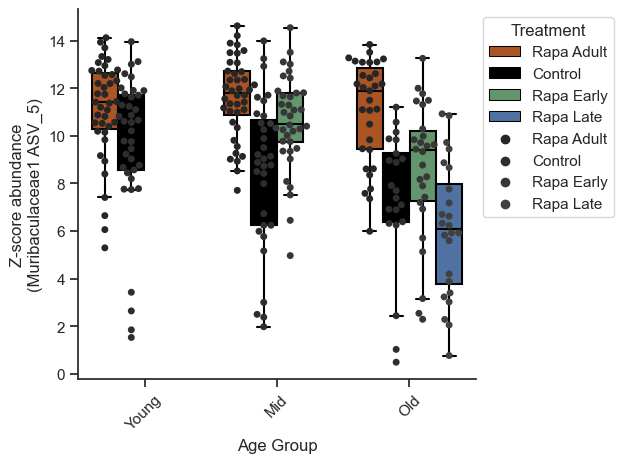

Lactobacillus1


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


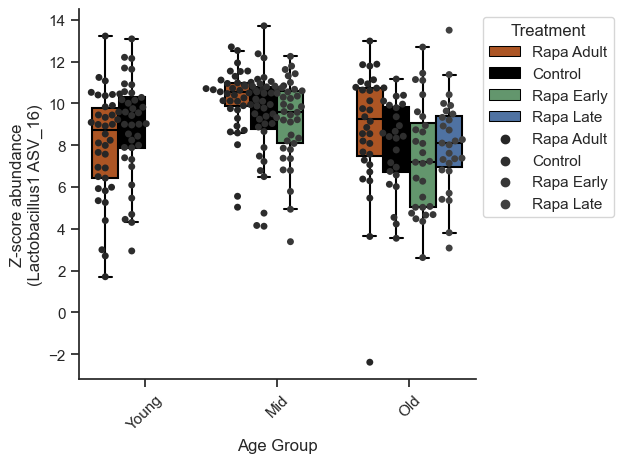

Lactobacillus2


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


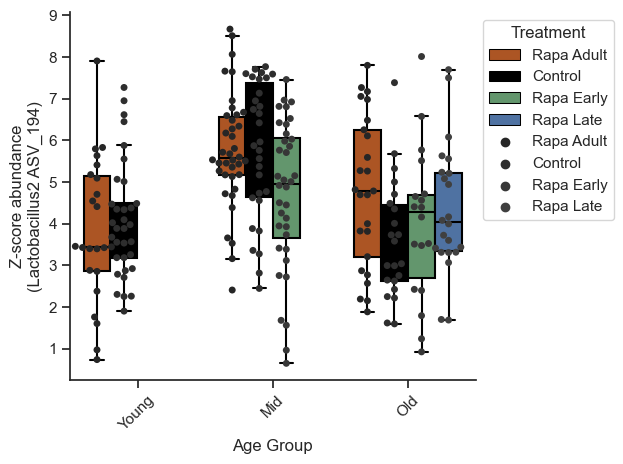

Lactobacillus3


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


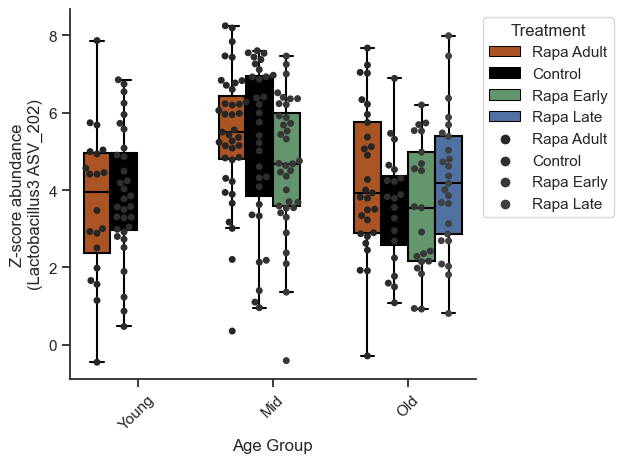

Muribaculaceae2


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


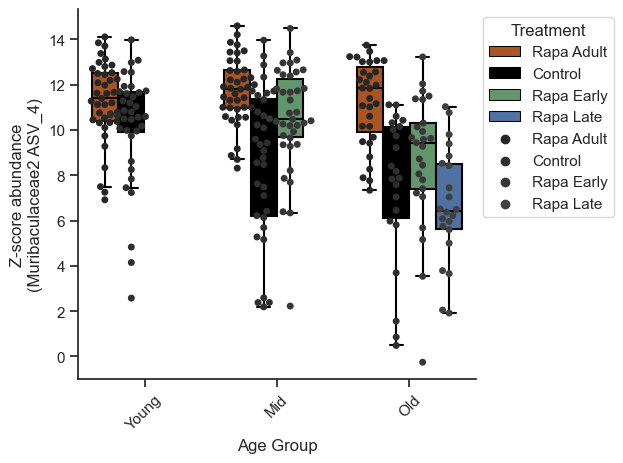

Muribaculaceae3


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


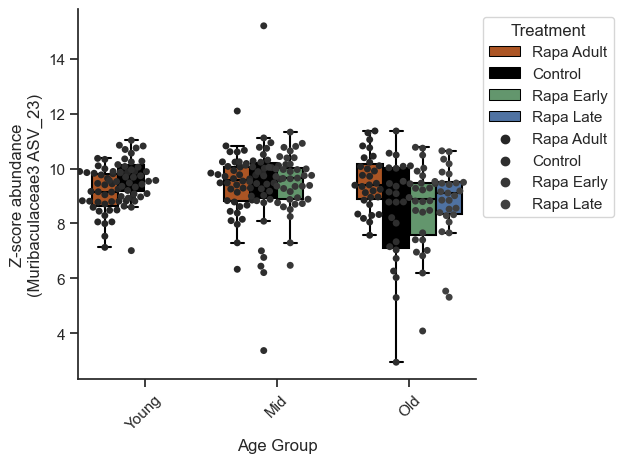

Muribaculaceae4


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


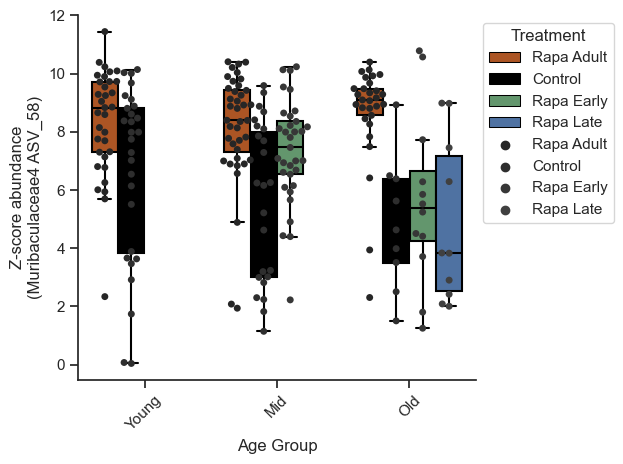

Muribaculaceae5


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


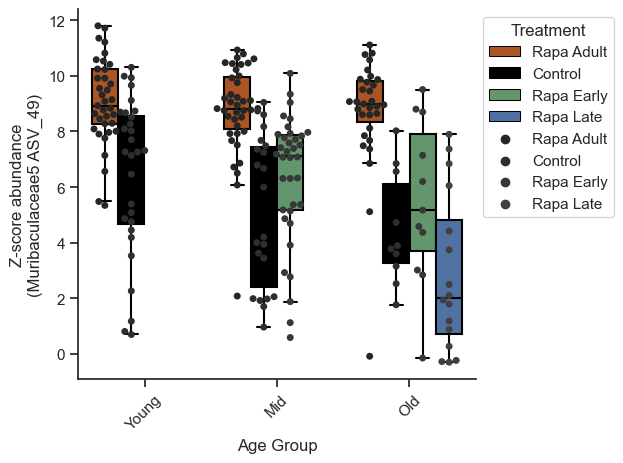

Muribaculaceae6


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


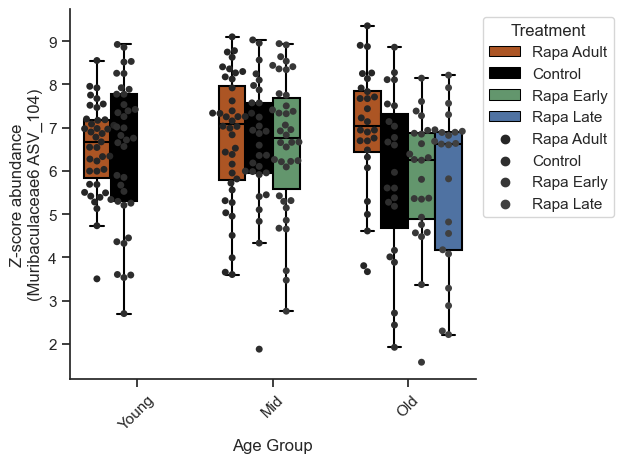

In [62]:
for e in list(ots.keys()):
    print(e)
    plot_expression(e)